Импорт основных библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Считываем все нужные таблицы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


Сортируем датасет, чтобы лаги были корректными

In [ ]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


Размер Датасета

In [ ]:
df.shape

(400, 2)

нулевых значений нет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

<Axes: ylabel='Цена на арматуру'>

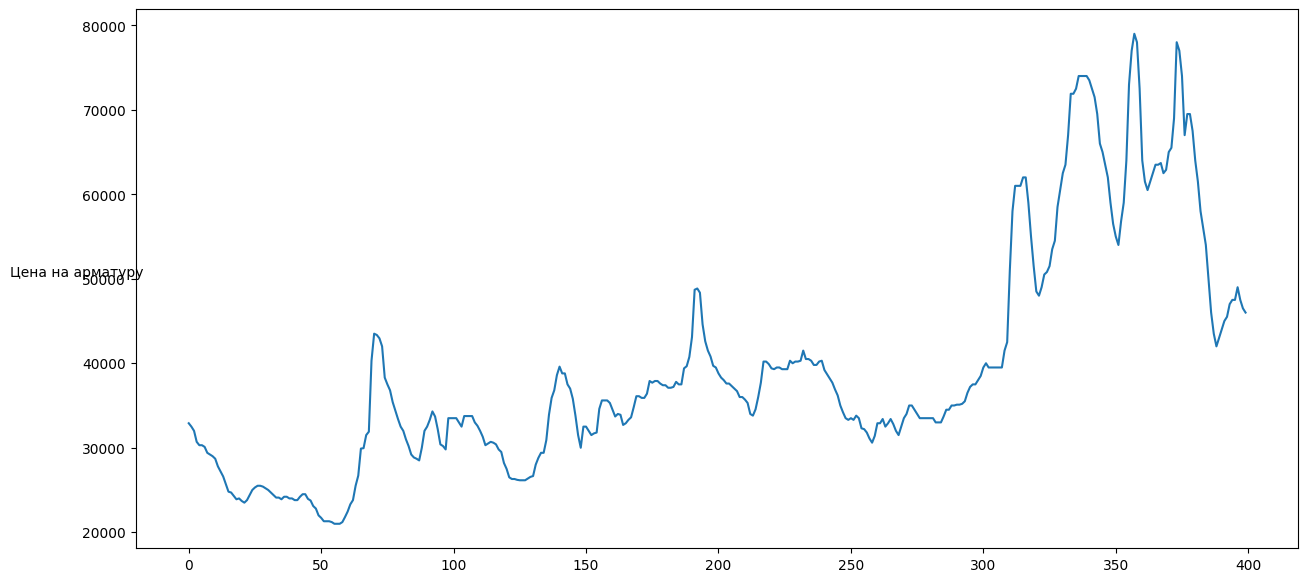

In [ ]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [ ]:
!pip install statsmodels==0.14.4

In [ ]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


Отсюда можем взять стат.характеристика как признаки для модели

In [ ]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [ ]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [ ]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты: тренд, сезоннотсь, шум, и оригинальные данные

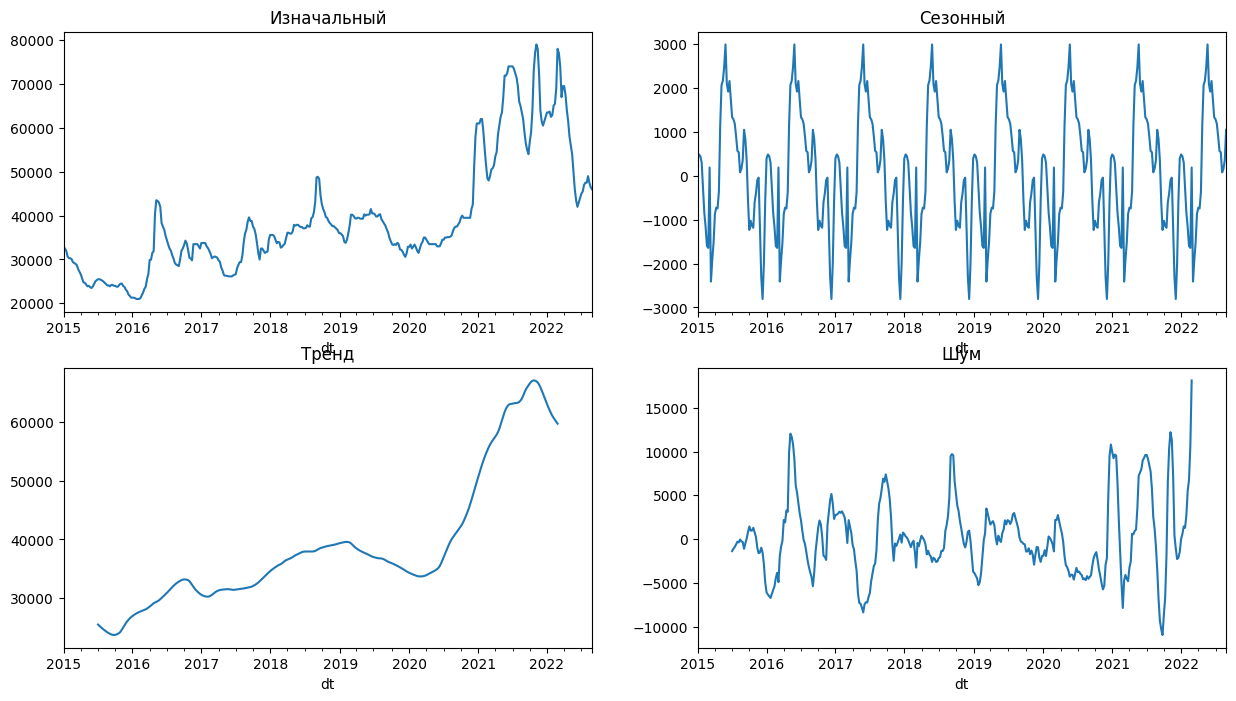

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


**Тест на стационарность**

можно предположить, т.к. p > 0.05, что временной ряд нестационарен

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf


def isit_stat(data):
  result = adfuller(data)
  if result[1] > 0.05:
    return 'ряд не стационарный'
  else:
    return 'стационарный'

# print('ADF Statistic:', result[0])
# print('p-value:', result[1])
isit_stat(df['Цена на арматуру'])

'ряд не стационарный'

**Автокорреляция и частичная автокорреляция**

Здесь мы можем увидеть важные лаги - те, которые не входят в закрашенную область

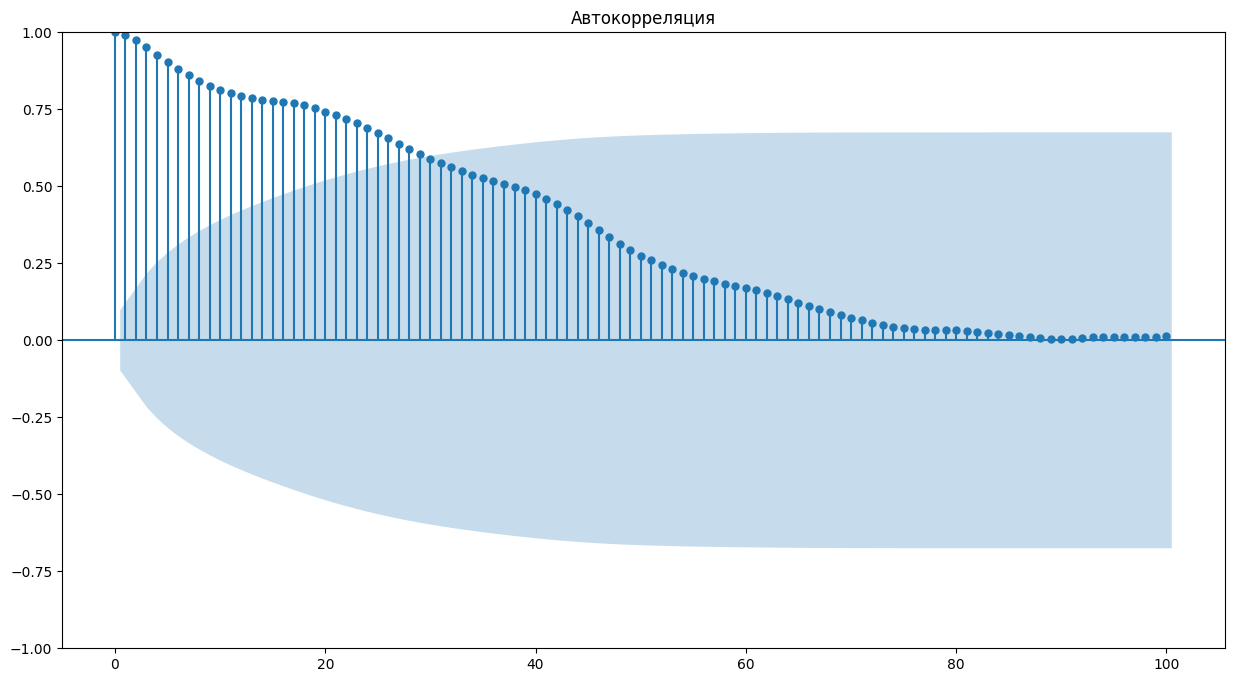

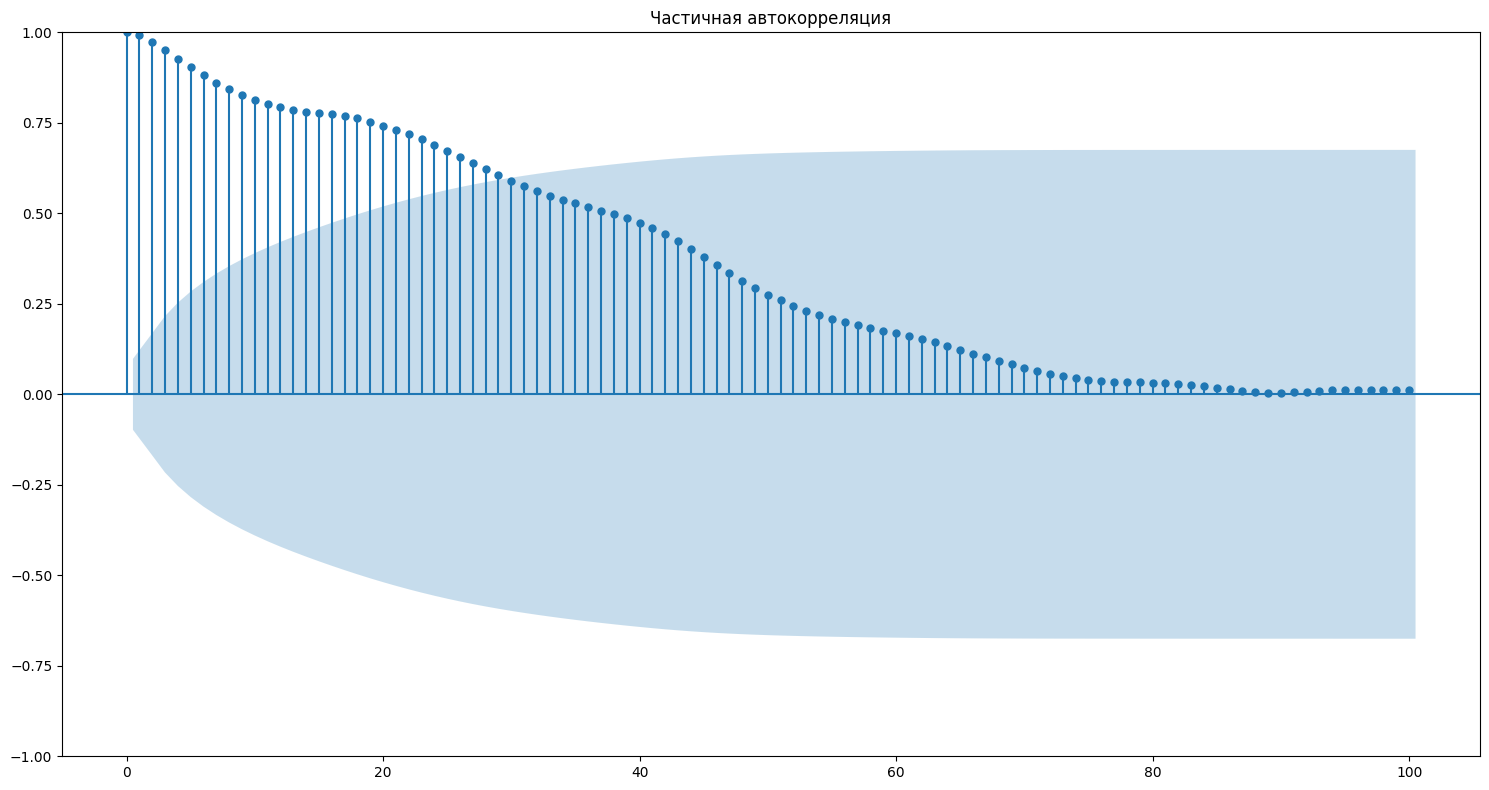

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Основные 25 лагов не входят в закрашенный промежток, значит значение из этого диапазона можно использовать как признаки для модели

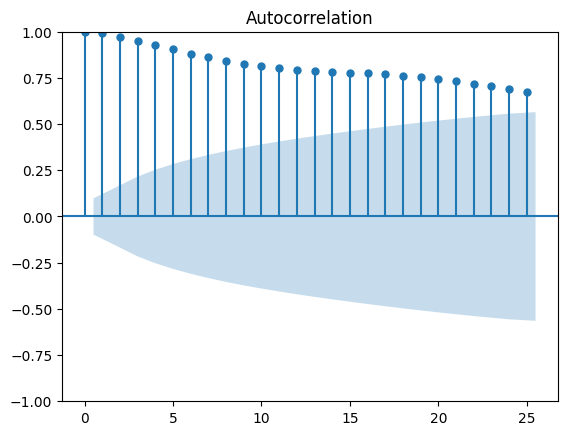

In [ ]:
plot_acf(df['Цена на арматуру'], lags=25)
plt.show()

# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


In [ ]:
df['df_diff'] = df['Цена на арматуру'].diff(1)

In [ ]:
from scipy.signal import medfilt

df['df_medfilt'] = medfilt(df['df_diff'], kernel_size=3)
df['df_medfilt']

,df_medfilt
dt,
2015-01-05,-400.0
2015-01-12,-400.0
2015-01-19,-500.0
2015-01-26,-500.0
2015-02-02,-400.0
...,...
2022-08-01,500.0
2022-08-08,0.0
2022-08-15,-1000.0


Ряд стал стационарным, всё, ура

In [ ]:
isit_stat(df['df_medfilt'])

'стационарный'

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

df.iloc[:, :] = imputer.fit_transform(df)

In [ ]:
train_size = int(len(df)*0.7)
train, test = df['df_medfilt'][:train_size], df['df_medfilt'][train_size:]


In [ ]:
!pip install numpy==1.23.5 pmdarima==2.0.4

In [ ]:
from pmdarima.arima import auto_arima


model = auto_arima(train, seasonal=True, m=52, stepwise=True, trace=True)

f'лучшие параметры модели {model.order}'

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4219.085, Time=43.93 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4499.796, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4235.601, Time=6.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4314.797, Time=7.51 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4498.672, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=4217.196, Time=7.73 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=4215.325, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=4217.195, Time=2.25 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=4213.575, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=4215.436, Time=2.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=4215.436, Time=2.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=4217.388, Time=8.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=4236.179, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=4215.162, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[52] intercept   : AIC=4215.699, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=4312.839, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[52] intercept   : AIC=4224.090, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=4213.252, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=4215.128, Time=2.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=4215.128, Time=2.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=4217.126, Time=18.63 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=4211.332, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=4213.209, Time=2.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=4213.209, Time=1.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=4215.206, Time=6.15 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=4233.955, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=4213.242, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[52] intercept   : AIC=4211.300, Time=2.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[52] intercept   : AIC=4213.216, Time=16.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[52] intercept   : AIC=4213.217, Time=14.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=17.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[52] intercept   : AIC=4213.048, Time=0.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=4212.964, Time=0.72 sec
 ARIMA(4,0,0)(0,0,0)[52] intercept   : AIC=4215.232, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[52] intercept   : AIC=4211.999, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[52]             : AIC=4209.566, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[52]             : AIC=4211.386, Time=10.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[52]             : AIC=4211.485, Time=5.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[52]             : AIC=inf, Time=16.37 sec
 ARIMA(2,0,1)(0,0,0)[52]             : AIC=4211.465, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[52]             : AIC=4211.451, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[52]             : AIC=4211.207, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[52]             : AIC=4211.103, Time=1.18 sec
 ARIMA(2,0,0)(0,0,0)[52]             : AIC=4209.539, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[52]             : AIC=4211.416, Time=2.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[52]             : AIC=4211.415, Time=3.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[52]             : AIC=4213.426, Time=4.88 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=4232.088, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[52]             : AIC=4213.318, Time=0.24 sec

Best model:  ARIMA(2,0,0)(0,0,0)[52]          
Total fit time: 217.654 seconds


'лучшие параметры модели (2, 0, 0)'

лучшие параметры модели (2, 0, 0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['df_medfilt'], order=(2, 1, 4))
fitted_model = arima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAE: 669.3294
RMSE: 1081.2676
SMAPE: 93.78%
R^2: 0.7340


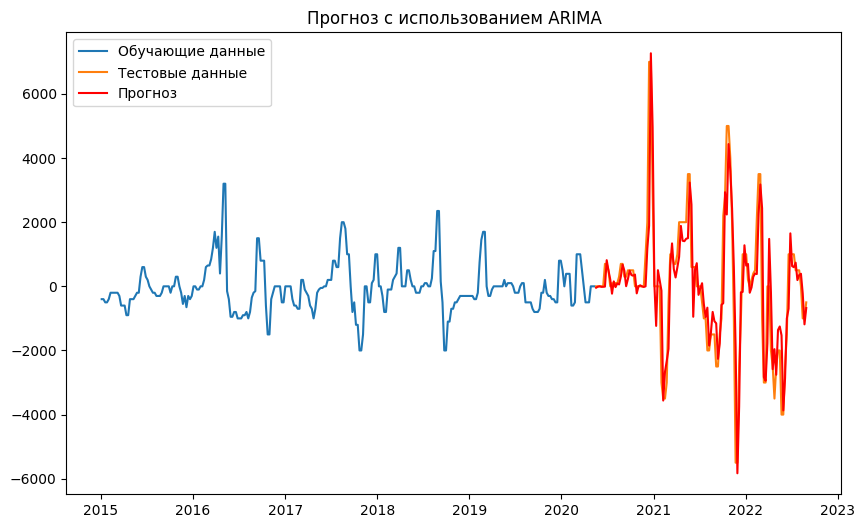

In [ ]:
forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

from sklearn.metrics import r2_score  # Импортируем r2_score

# Средняя абсолютная ошибка (MAE)
from sklearn.metrics import  mean_squared_error, mean_absolute_error

mae_a = mean_absolute_error(test, forecast)
print(f"MAE: {mae_a:.4f}")

# Корень среднеквадратичной ошибки (RMSE)
rmse_a = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse_a:.4f}")

# Симметричная MAPE (SMAPE)
smape_a = np.mean(2 * np.abs(forecast - test) / (np.abs(test) + np.abs(forecast))) * 100
print(f"SMAPE: {smape_a:.2f}%")

# Коэффициент детерминации (R^2)
r2_a = r2_score(test, forecast)
print(f"R^2: {r2_a:.4f}")

# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train, label='Обучающие данные')
plt.plot(test, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()

строим график прогноза

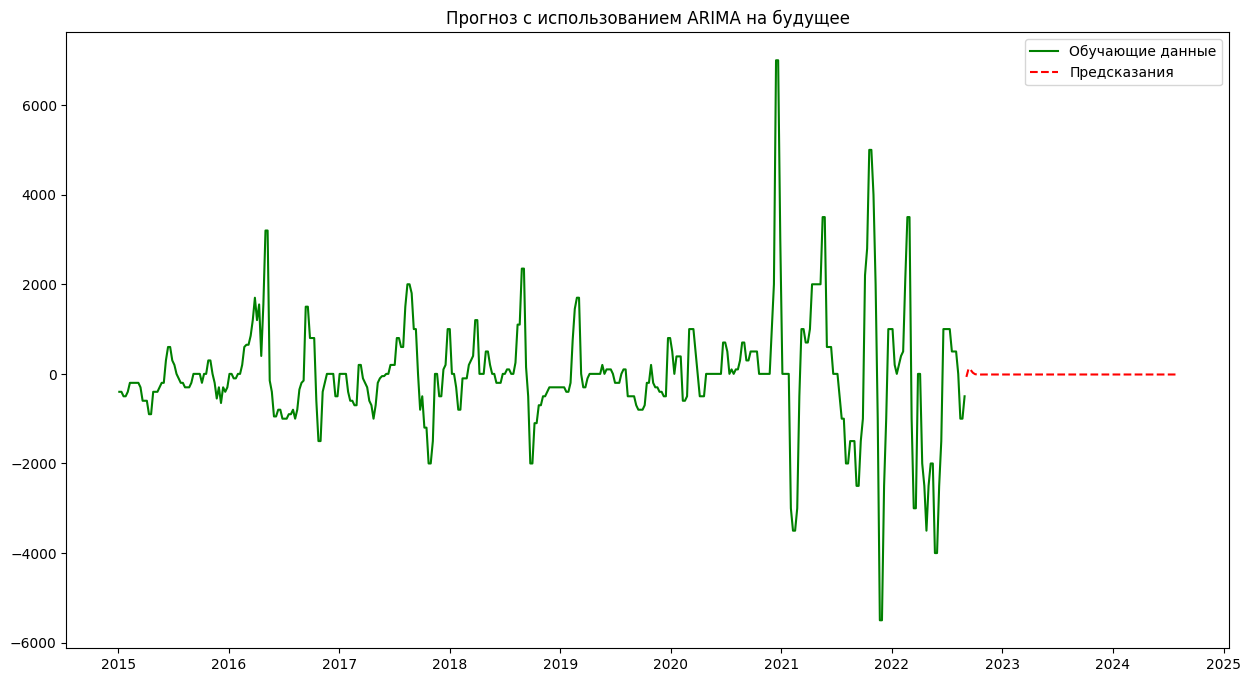

In [ ]:


future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=100, freq='W')

plt.figure(figsize=(15,8))

plt.plot(df.index, df['df_medfilt'], label='Обучающие данные', color='green')

plt.plot(future_dates, arima_forecast, label='Предсказания', color='red', linestyle='dashed')

plt.title('Прогноз с использованием ARIMA на будущее')
plt.legend()

# Показать график
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                         df_medfilt   No. Observations:                  320
Model:             SARIMAX(1, 1, 1)x(1, 2, 1, 52)   Log Likelihood               -1771.144
Date:                            Thu, 27 Mar 2025   AIC                           3552.288
Time:                                    06:36:36   BIC                           3569.141
Sample:                                01-05-2015   HQIC                          3559.098
                                     - 02-15-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0613      0.176     -0.349      0.727      -0.406       0.283
ma.L1          0.3010      0.163   

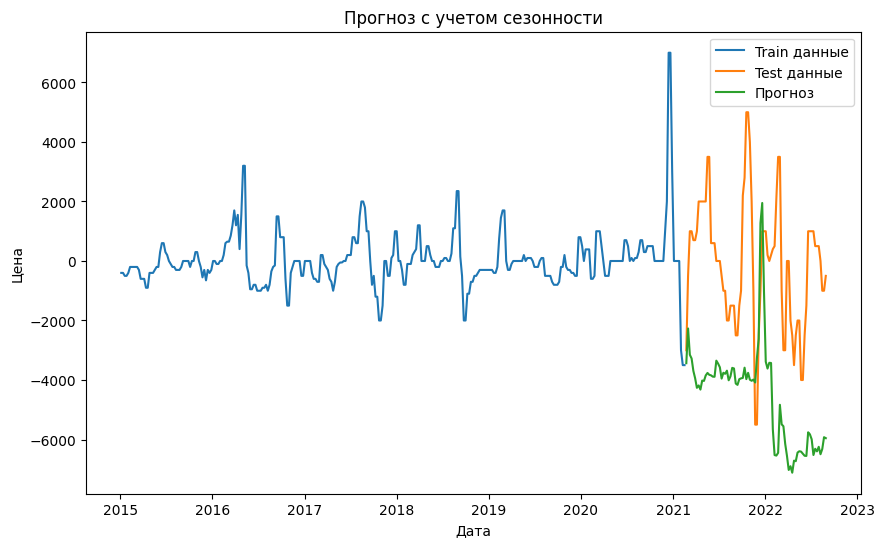

In [ ]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Загрузка данных
data = df['df_medfilt']

# Разделение данных на обучающую и тестовую выборки
train_size_sa = int(len(data) * 0.8)
train_sa, test_sa = data[:train_size_sa], data[train_size_sa:]

# Создание и обучение модели SARIMA с заданными параметрами
model = SARIMAX(
    train_sa,
    order=(1, 1, 1),              # Несезонные параметры (p, d, q)
    seasonal_order=(1, 2, 1, 52)  # Сезонные параметры (P, D, Q, m)
)
results = model.fit()

# Вывод результатов обучения
print(results.summary())

# Прогнозирование на test данные
forecast_sa = results.get_forecast(steps=len(test_sa)).predicted_mean

# Вычисление метрик качества модели
# 1. Средняя абсолютная ошибка (MAE)
mae_sa = mean_absolute_error(test_sa, forecast_sa)

# 2. Корень среднеквадратичной ошибки (RMSE)
rmse_sa = np.sqrt(mean_squared_error(test_sa, forecast_sa))

# 3. Симметричная MAPE (SMAPE)
smape_sa = np.mean(2 * np.abs(test_sa - forecast_sa) / (np.abs(test_sa) + np.abs(forecast_sa))) * 100

# 4. Коэффициент детерминации (R^2)
r2_sa = r2_score(test_sa, forecast_sa)



# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae_sa:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_sa:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape_sa:.2f}%")
print(f"Коэффициент детерминации (R^2): {r2_sa:.4f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(train_sa.index, train_sa, label='Train данные')  # Обучающие данные
plt.plot(test_sa.index, test_sa, label='Test данные')    # Фактические значения test данных
plt.plot(test_sa.index, forecast_sa, label='Прогноз')    # Прогноз модели
plt.title('Прогноз с учетом сезонности')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

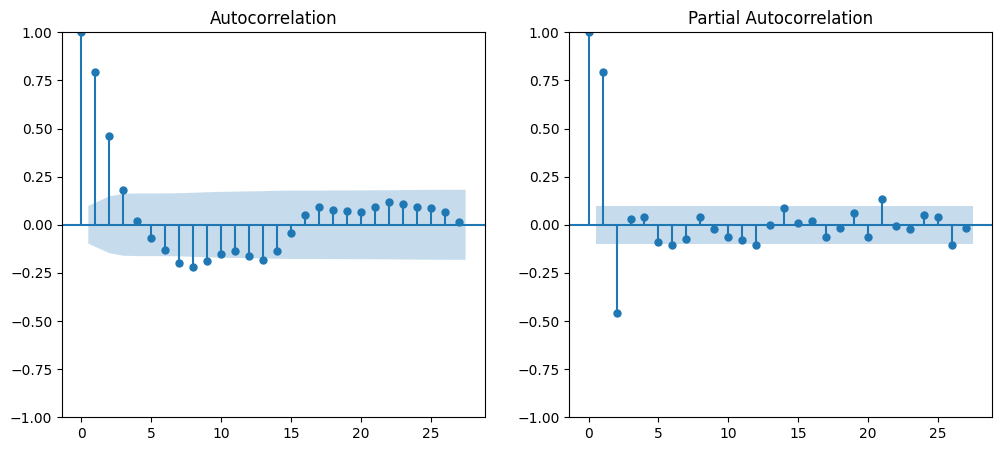

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_acf(df['df_medfilt'].dropna(), ax=ax[0])  # ACF - находим q
plot_pacf(df['df_medfilt'].dropna(), ax=ax[1]) # PACF - находим p
plt.show()


In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

df.iloc[:, :] = imputer.fit_transform(df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 13.4727 - val_loss: 0.0514
Epoch 2/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1527 - val_loss: 0.0855
Epoch 3/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0383 - val_loss: 0.1832
Epoch 4/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0273 - val_loss: 0.1460
Epoch 5/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0127 - val_loss: 0.0253
Epoch 6/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0110 - val_loss: 0.0483
Epoch 7/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0085 - val_loss: 0.0658
Epoch 8/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0071 - val_loss: 0.0521
Epoch 9/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0064 - val_loss: 0.0508
Epoch 10/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0046 - val_loss: 0.0603
Epoch 11/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0066 - val_loss: 0.0404
Epoch 12/49
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0

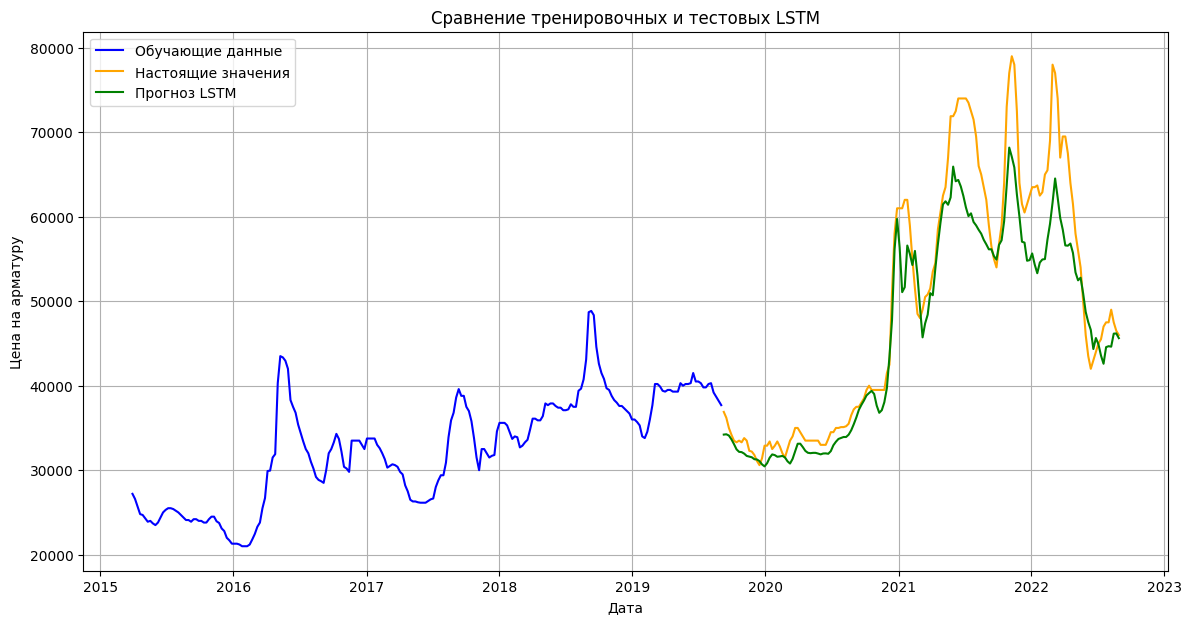

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import os
import random
import tensorflow



seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values

# масштабирование, чтобы модель работала корректно
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# объединяем целевую переменную и дополнительные признаки
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # все признаки
        y.append(data[i + timesteps, 0])  # целевая переменная
    return np.array(X), np.array(y)

# параметры
timesteps = 12  # кол. временных шагов
X, y = create_dataset(data_scaled, timesteps)


train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


model = Sequential()
model.add(LSTM(97, return_sequences=False, input_shape=(timesteps, X_train.shape[2])))  # Первый LSTM-слой
model.add(Dropout(0.3))
model.add(Dense(1))  # ыыходной слой



# learning_rate = 0.005669387181782102
learning_rate = 0.100589
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# ОБУЧЕНИЕ
history = model.fit(X_train, y_train, epochs=49, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ПРОГНОЗ
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# МЕТРИКИ
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred)
print(f'R²: {r2:.4f}')

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Сравнение тренировочных и тестовых LSTM')
plt.legend()
plt.grid()
plt.show()

Больше похоже на квадратный корень чем предсказание модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Прогноз на 6 недель вперед: [np.float32(45629.535), np.float32(43265.99), np.float32(5634.7197), np.float32(0.0), np.float32(12940.598), np.float32(26752.521)]


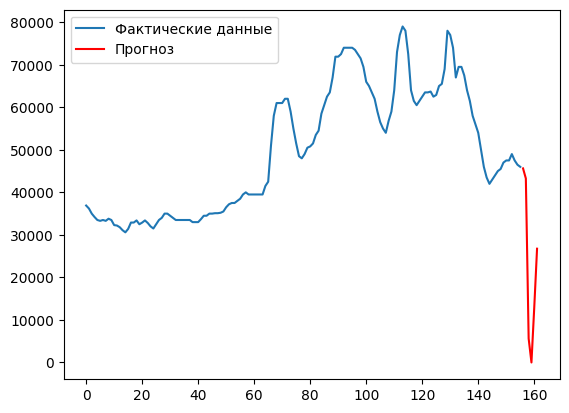

In [ ]:
future_steps = 6
last_sequence = X_test[-1]
forecast = []

for _ in range(future_steps):
    next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]))
    next_pred = scaler_target.inverse_transform(next_pred_scaled)


    next_pred = np.maximum(0, next_pred)  #ограничение чтобы минус не предсказывала

    forecast.append(next_pred[0, 0])

    # обновление
    next_features = last_sequence[1:]
    next_pred_scaled_for_input = np.hstack((next_pred_scaled, np.zeros((1, X_train.shape[2] - 1))))
    last_sequence = np.vstack((next_features, next_pred_scaled_for_input))

print(f"Прогноз на {future_steps} недель вперед:", forecast)

plt.plot(range(len(y_test_original)), y_test_original, label="Фактические данные")
plt.plot(range(len(y_test_original), len(y_test_original) + future_steps), forecast, label="Прогноз", color="red")
plt.legend()
plt.show()

Сохраняем предсказания в таблицу

In [ ]:
lstm_forecast = model.predict(X_test)

# новый df с датами и предсказаниями
lstm_predictions = pd.DataFrame({
    "dt": df.index[train_size + timesteps:],  # даты
    "LSTM_Pred": y_pred.flatten()
})

# csv файл
lstm_predictions.to_csv("lstm_predictions.csv", index=False)
print("Файл lstm_predictions.csv сохранен!")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Файл lstm_predictions.csv сохранен!


In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pandas as pd
import pickle

# Загрузка модели
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Загрузка тестовых данных
test_data = pd.read_excel('/content/drive/MyDrive/ML_3/test.xlsx', parse_dates=['dt'])

# Прогнозирование для каждой даты
predictions = []

for date in test_data['dt']:
    # Прогноз на 6 недель вперед
    future_steps = 150
    last_sequence = X_test[-1]
    forecast = []

    for _ in range(future_steps):
      next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]))
      next_pred = scaler_target.inverse_transform(next_pred_scaled)


      next_pred = np.maximum(0, next_pred)  #ограничение чтобы минус не предсказывала

      forecast.append(next_pred[0, 0])

    # обновление
      next_features = last_sequence[1:]
      next_pred_scaled_for_input = np.hstack((next_pred_scaled, np.zeros((1, X_train.shape[2] - 1))))
      last_sequence = np.vstack((next_features, next_pred_scaled_for_input))


    # Определение объема закупки
    if forecast[0] > forecast[-1]:  # Если цена растет
        n_weeks = 6
    else:  # Если цена снижается
        n_weeks = 1

    predictions.append(n_weeks)

# Добавление прогноза в тестовые данные
test_data['N_weeks'] = predictions

# Сохранение результатов
test_data.to_excel('test.xlsx', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.2 MB/s eta 0:00:00


Подбираем лучшие параметры для модели

In [ ]:
import optuna

def objective(trial):
    # нужные гиперпараметры
    timesteps = trial.suggest_int("timesteps", 3, 14)
    lstm_units = trial.suggest_int("lstm_units", 32, 100)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 20, 100)
    lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)


    X, y = create_dataset(data_scaled, timesteps)
    train_size = int(len(X) * 0.6)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(timesteps, X_train.shape[2])),
        LSTM(lstm_units, return_sequences=False),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # прогноз
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # вычисление ошибки
    rmse = mean_squared_error(y_test_original, y_pred) ** 0.5
    return rmse

# оптимизация
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # кол. вариантов параметров


print("Лучшие параметры:", study.best_params)


[I 2025-03-23 10:24:28,022] A new study created in memory with name: no-name-562d4b9c-7a48-4015-8546-3e0fb66ec420
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:25:07,780] Trial 0 finished with value: 7236.461578009886 and parameters: {'timesteps': 12, 'lstm_units': 65, 'batch_size': 32, 'epochs': 37, 'learning_rate': 0.00021269900201150625}. Best is trial 0 with value: 7236.461578009886.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:25:28,374] Trial 1 finished with value: 8274.823685449612 and parameters: {'timesteps': 11, 'lstm_units': 33, 'batch_size': 32, 'epochs': 88, 'learning_rate': 0.006340988884397517}. Best is trial 0 with value: 7236.461578009886.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-03-23 10:25:36,920] Trial 2 finished with value: 6941.384610557483 and parameters: {'timesteps': 6, 'lstm_units': 35, 'batch_size': 64, 'epochs': 37, 'learning_rate': 0.005635294554694786}. Best is trial 2 with value: 6941.384610557483.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


[I 2025-03-23 10:25:49,096] Trial 3 finished with value: 7168.050613402426 and parameters: {'timesteps': 11, 'lstm_units': 83, 'batch_size': 64, 'epochs': 34, 'learning_rate': 0.00015416065624163458}. Best is trial 2 with value: 6941.384610557483.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:26:01,260] Trial 4 finished with value: 5986.793383179196 and parameters: {'timesteps': 6, 'lstm_units': 92, 'batch_size': 64, 'epochs': 45, 'learning_rate': 0.0012064453431243343}. Best is trial 4 with value: 5986.793383179196.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:26:15,371] Trial 5 finished with value: 5491.67792761793 and parameters: {'timesteps': 4, 'lstm_units': 85, 'batch_size': 32, 'epochs': 34, 'learning_rate': 0.0009828110047111617}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-03-23 10:26:35,623] Trial 6 finished with value: 6690.8970545154825 and parameters: {'timesteps': 12, 'lstm_units': 91, 'batch_size': 32, 'epochs': 40, 'learning_rate': 0.00021387132938170244}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-03-23 10:26:51,532] Trial 7 finished with value: 5535.7098472849675 and parameters: {'timesteps': 5, 'lstm_units': 85, 'batch_size': 64, 'epochs': 58, 'learning_rate': 0.0001604784607646624}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2025-03-23 10:27:16,666] Trial 8 finished with value: 6484.785415008177 and parameters: {'timesteps': 14, 'lstm_units': 85, 'batch_size': 32, 'epochs': 69, 'learning_rate': 0.0015785375843858367}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2025-03-23 10:27:47,048] Trial 9 finished with value: 8585.451881598772 and parameters: {'timesteps': 14, 'lstm_units': 41, 'batch_size': 16, 'epochs': 85, 'learning_rate': 0.0003361242481906589}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2025-03-23 10:28:03,510] Trial 10 finished with value: 5960.1375644261225 and parameters: {'timesteps': 3, 'lstm_units': 67, 'batch_size': 16, 'epochs': 60, 'learning_rate': 0.0006518407652597694}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2025-03-23 10:28:14,959] Trial 11 finished with value: 7109.53785803542 and parameters: {'timesteps': 3, 'lstm_units': 71, 'batch_size': 64, 'epochs': 58, 'learning_rate': 0.002034033071570397}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-03-23 10:28:24,581] Trial 12 finished with value: 5529.707546238298 and parameters: {'timesteps': 6, 'lstm_units': 99, 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0005361872245357013}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2025-03-23 10:28:36,147] Trial 13 finished with value: 6528.05362757661 and parameters: {'timesteps': 8, 'lstm_units': 100, 'batch_size': 32, 'epochs': 21, 'learning_rate': 0.0005370576201144222}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-03-23 10:28:44,934] Trial 14 finished with value: 7636.51136209871 and parameters: {'timesteps': 8, 'lstm_units': 100, 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.003059036171612665}. Best is trial 5 with value: 5491.67792761793.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-03-23 10:28:54,138] Trial 15 finished with value: 5460.712576256488 and parameters: {'timesteps': 5, 'lstm_units': 74, 'batch_size': 32, 'epochs': 25, 'learning_rate': 0.0006952492034037124}. Best is trial 15 with value: 5460.712576256488.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-03-23 10:29:03,960] Trial 16 finished with value: 4291.118251885764 and parameters: {'timesteps': 4, 'lstm_units': 53, 'batch_size': 32, 'epochs': 31, 'learning_rate': 0.0008778716861087405}. Best is trial 16 with value: 4291.118251885764.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-03-23 10:29:17,496] Trial 17 finished with value: 3954.9069456645316 and parameters: {'timesteps': 5, 'lstm_units': 51, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.0028137691888126303}. Best is trial 17 with value: 3954.9069456645316.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-03-23 10:29:34,996] Trial 18 finished with value: 6451.246437942751 and parameters: {'timesteps': 9, 'lstm_units': 52, 'batch_size': 16, 'epochs': 49, 'learning_rate': 0.00315182163796065}. Best is trial 17 with value: 3954.9069456645316.
<ipython-input-28-08a1eb3ee961>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 0.0001, 0.01)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2025-03-23 10:30:00,957] Trial 19 finished with value: 5811.637737216615 and parameters: {'timesteps': 7, 'lstm_units': 54, 'batch_size': 16, 'epochs': 73, 'learning_rate': 0.009916183411349207}. Best is trial 17 with value: 3954.9069456645316.


Лучшие параметры: {'timesteps': 5, 'lstm_units': 51, 'batch_size': 16, 'epochs': 50, 'learning_rate': 0.0028137691888126303}


Проверяем работу модели на тестовых данных

In [ ]:
test_data = pd.read_excel('')

что-то нормальное

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import os
import random
import tensorflow



seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values

# масштабирование, чтобы модель работала корректно
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# объединяем целевую переменную и дополнительные признаки
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # все признаки
        y.append(data[i + timesteps, 0])  # целевая переменная
    return np.array(X), np.array(y)

# параметры
timesteps = 12  # кол. временных шагов
X, y = create_dataset(data_scaled, timesteps)


train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


model = Sequential()
model.add(LSTM(97, return_sequences=False, input_shape=(timesteps, X_train.shape[2])))  # Первый LSTM-слой
model.add(Dropout(0.3))
model.add(Dense(1))  # ыыходной слой



# learning_rate = 0.005669387181782102
learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# ОБУЧЕНИЕ
history = model.fit(X_train, y_train, epochs=49, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ПРОГНОЗ
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# МЕТРИКИ
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred)
print(f'R²: {r2:.4f}')

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Сравнение тренировочных и тестовых LSTM')
plt.legend()
plt.grid()
plt.show()